AAE for CIFAR10

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.utils.data as data
import torch.optim as optim
from torchvision.utils import make_grid
import torchvision.transforms as transforms


import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

In [2]:
def load_pickle(path): # .pkl to numpy ndarray#
  with open(path,'rb') as f:
    data = pickle.load(f)
  train_data, test_data = data['train'], data['test']
  #print(type(train_data))
  return  train_data, test_data

In [3]:
def show_samples(samples,title,nrow = 10):
  samples = (torch.FloatTensor(samples)/255).permute(0,3,2,1) 
  # permute because in pytorch should be such consequence <batch size, image channel, image height, image width>.
  grid_img = make_grid(samples, nrow=nrow)
  plt.figure()
  plt.title(title)
  plt.imshow(grid_img.permute(1,2,0))
  plt.axis('off')
  plt.show()

In [4]:
def visualize_data(data,title):
  idxs = np.random.choice(len(data),replace=False, size = (100,))
  images = data[idxs]
  show_samples(images,title)

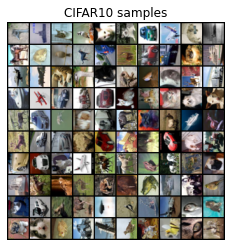

In [7]:
path = os.path.join('drive', 'My Drive','cifar10.pkl')
train_data, test_data = load_pickle(path)
visualize_data(train_data,'CIFAR10 samples')

It is worth noticing that encoder is able to encode data distribution to a latent vector, but not mean and scale of latent distribution. It's like advantage of this approach.

In [8]:
class Encoder(nn.Module):
  def __init__(self, n_latent):
    super(Encoder,self).__init__()
    self.net = nn.Sequential(
        
        nn.Conv2d(in_channels= 3, out_channels= 6, kernel_size= 4, stride = 2, padding = 1, bias= False),
        nn.BatchNorm2d(num_features = 6),
        nn.LeakyReLU(0.2,inplace=True),

        nn.Conv2d(in_channels = 6,out_channels = 12, kernel_size = 4, stride = 2,padding = 1, bias = False),
        nn.BatchNorm2d(num_features = 12),
        nn.LeakyReLU(0.2,inplace=True),

        nn.Conv2d(in_channels= 12, out_channels = 24, kernel_size = 4, stride=2, padding = 1, bias =False),
        nn.BatchNorm2d(24),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Flatten(), # From Conv2D to Linear MLP
        nn.Linear(in_features = 24*4*4, out_features= 1024),
        nn.BatchNorm1d(num_features = 1024),
        nn.LeakyReLU(0.2, inplace=True)
    )
    self.latent_layer = nn.Linear(1024, n_latent)

  # at first, will try to assump that variance distribution from normal
  # after, will not use certain distribution and will trust to neural network(encoder)
  def forward(self, input):
    output = self.net(input)
    latent_output = self.latent_layer(output)
    # 2* n_latent values in latent_output
    #mu_z, log_std_z = latent_output.chunk(2, dim=1)
    return latent_output

In [9]:
class Unflatten(nn.Module):
  def __init__(self,shape):
    super(Unflatten,self).__init__()
    self.shape = shape
  
  def forward(self, input):
    answer = input.view(len(input) , self.shape[0],self.shape[1],self.shape[2])
    return answer

As for the Decoder, there is the same. It is able to decode latent vector to image. As soon as we calculate reconstruction loss, one can backpropogate gradients through the decoder and the encoder.

In [10]:
class Decoder(nn.Module):
  
  def __init__(self,n_latent):
    super(Decoder,self).__init__()
    self.net = nn.Sequential(
        
        nn.Linear(n_latent,1024),
        nn.Linear(1024,24*4*4),
        nn.BatchNorm1d(24*4*4),
        nn.LeakyReLU(0.2, inplace = True),
        Unflatten((24,4,4)),


        
        nn.ConvTranspose2d(in_channels= 24 ,out_channels= 12 ,kernel_size = 7   ,stride = 1 ,padding = 1 ,bias=False),
        nn.BatchNorm2d(12),
        nn.LeakyReLU(0.2, inplace = True),

        nn.ConvTranspose2d(12,6, kernel_size = 4, stride = 2, padding=1, bias=False),
        nn.BatchNorm2d(6),
        nn.LeakyReLU(0.2, inplace = True),

        nn.ConvTranspose2d(6,3, kernel_size = 4, stride=2,padding=1, bias =False),
        nn.BatchNorm2d(3),
        nn.LeakyReLU(0.2, inplace = True),

        nn.Conv2d(3,3,kernel_size=3, stride = 1, padding = 1 ,bias=False),
        nn.Tanh()
    )
    
  def forward(self, input):
    return self.net(input)


In [11]:
class Discriminator(nn.Module):
  def __init__(self,n_latent):
    super(Discriminator,self).__init__()
    self.net = nn.Sequential(
        nn.Linear(n_latent,1000),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Linear(1000,1000),
        nn.LeakyReLU(0.2, inplace= True),
        nn.Linear(1000,1),
        nn.Sigmoid()

    )
  def forward(self, input):
    return self.net(input)

As you may have already guessed we don't create the generator. Encoder constitutes usual encoder while there is reconstruction training, nevertheless encoder is transformed to a generator when adversarial training.

In [12]:
n_latent = 60
encoder = Encoder(n_latent)
decoder = Decoder(n_latent)
discriminator = Discriminator(n_latent)

In [13]:
BATCH_SIZE = 50
minimax_lr = 1e-3 # lr for adversarial loss
reconstruction_lr = 1e-3 # lr for reconstruction loss
EPOCHS = 5
EPS =1e-15

In [14]:
transform = torchvision.transforms.Compose([transforms.ToTensor()])

In [15]:
data_train = torchvision.datasets.CIFAR10(root='./data',train=True,transform=transform,download =True)
data_test = torchvision.datasets.CIFAR10(root='./data',train=False,transform=transform,download=True)
train_loader = torch.utils.data.DataLoader(dataset=data_train,batch_size = BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=data_test, batch_size=BATCH_SIZE,shuffle=False)

Failed download. Trying https -> http instead. Downloading http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


There are generator optimizer and encoder optimizer deal with the encoder as was mentioned above.

In [16]:
encoder_optim = optim.Adam(encoder.parameters(),lr= reconstruction_lr)
generator_optim = optim.Adam(encoder.parameters(),lr= minimax_lr)
decoder_optim = optim.Adam(decoder.parameters(),lr= reconstruction_lr)
discriminator_optim = optim.Adam(discriminator.parameters(),lr = minimax_lr)

The following image constitutes the process of training.




1.   encoding data to latent vector, but not parameters
2.   encoding latent vector to data distribution
3.   reconstruction error backpropogation
4.   sending sample from prior and latent vector to Discriminator
5.   Train Discriminator and its backprop
6.   Train Generator and its backprop by fixed Discriminator




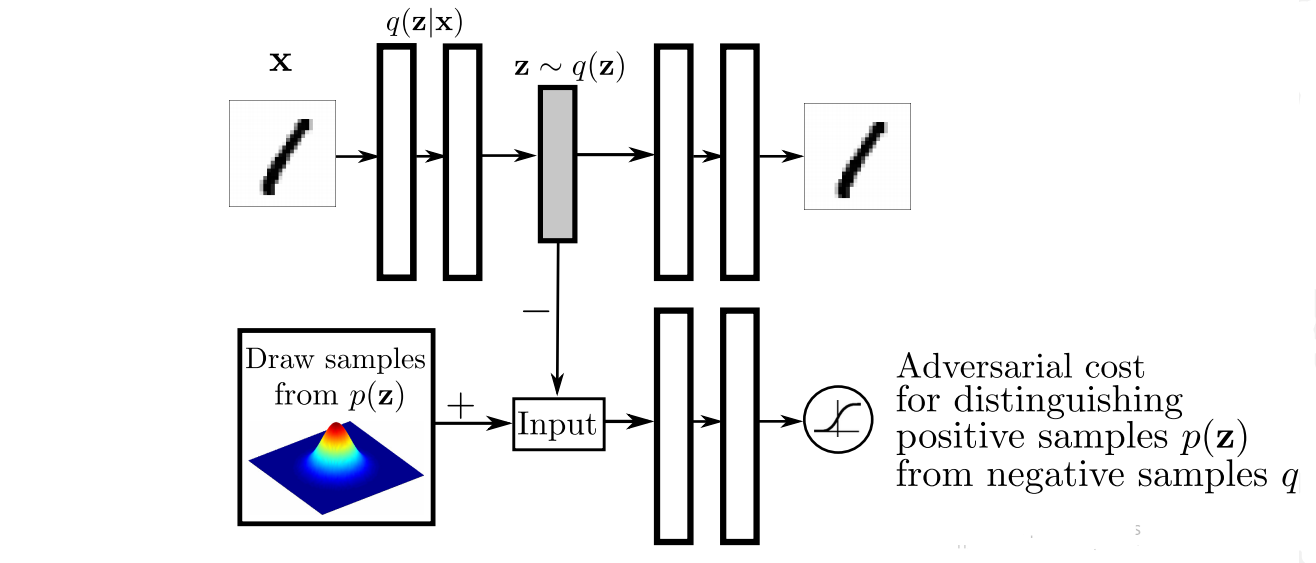

In [17]:
def train_model(num_epochs, train_loader, encoder, decoder, discriminator ):

  reconstruction_loss = []
  generator_loss = []
  discriminator_loss = []

  encoder_optim = optim.Adam(encoder.parameters(),lr= reconstruction_lr)
  generator_optim = optim.Adam(encoder.parameters(),lr= minimax_lr)
  decoder_optim = optim.Adam(decoder.parameters(),lr= reconstruction_lr)
  discriminator_optim = optim.Adam(discriminator.parameters(),lr = minimax_lr)

  for epoch in range(num_epochs):
    
    encoder.train()
    decoder.train()
    discriminator.train()

    for data,_ in tqdm_notebook(train_loader):
      
      encoder_optim.zero_grad()
      decoder_optim.zero_grad()
      discriminator_optim.zero_grad()
      generator_optim.zero_grad()

      ##### reconstruction loss #####
      latent_sample = encoder(data)
      # latent_sample.shape == torch.Size[Batch_size, n_latent = 60]
      x_sample = decoder(latent_sample)
      # x_sample.shape == torch.Size[Batch_size, 3, 32,32]
      # data.shape == torch.Size([Batch_size, 3, 32, 32])
      

      recon_loss = F.mse_loss(x_sample,data,reduction='none')
      # recon_loss.shape == torch.Size([Batch_size,3,32,32])
      recon_loss = recon_loss.view(BATCH_SIZE,-1).sum(1).mean()
      reconstruction_loss.append(recon_loss.item())
      
      recon_loss.backward()
      encoder_optim.step()
      decoder_optim.step()


      #### discriminator loss   #####

      encoder.eval()
      real_latent = torch.randn(BATCH_SIZE,n_latent)
      # real_latent.shape == torch.Size([BATCH_SIZE,n_latent])
      real_discriminator = discriminator(real_latent)
      # real_discriminator.shape == torch.Size([Batch_Size,1])

      fake_latent = encoder(data)
      fake_discriminator = discriminator(fake_latent)
      #fake_discriminator.shape == torch.Size([Batch_size,1])
      
      discr_loss = -torch.mean(torch.log(real_discriminator + EPS) + torch.log( 1 - fake_discriminator + EPS))
      discriminator_loss.append(discr_loss)
      discr_loss.backward()
      discriminator_optim.step()
      

      ####   generator   loss   ####
      encoder.train()

      fake_latent = encoder(data)
      fake_discriminator = discriminator(fake_latent)

      gen_loss = -torch.mean(torch.log(fake_discriminator + EPS))
      generator_loss.append(gen_loss)
      gen_loss.backward()
      generator_optim.step()
      


  return reconstruction_loss, discriminator_loss, generator_loss

In [19]:
import tqdm
from tqdm import tqdm_notebook

In [20]:
reconstruction_loss, discriminator_loss, generator_loss =   train_model(EPOCHS,train_loader,encoder, decoder, discriminator )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


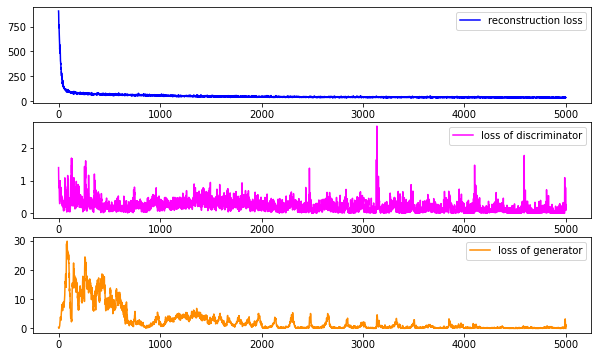

In [21]:
fig,ax = plt.subplots(3,1,figsize=(10,6))
ax[0].plot(reconstruction_loss, color = 'blue', label = 'reconstruction loss')
ax[1].plot(discriminator_loss,color='magenta', label = 'loss of discriminator')
ax[2].plot(generator_loss,color='darkorange', label = 'loss of generator')
ax[1].legend()
ax[0].legend()
ax[2].legend()
plt.show()

Reconstruction of one object

In [72]:
def show_samples_redefine(samples,title,nrow = 6):
  #samples = (torch.FloatTensor(samples)/255).permute(0,3,2,1) 
  # permute because in pytorch should be such consequence <batch size, image channel, image height, image width>.
  grid_img = make_grid(samples, nrow=nrow)
  plt.figure()
  plt.title(title)
  plt.imshow(grid_img.permute(1,2,0))
  plt.axis('off')
  plt.show()

In [73]:
image = next(iter(train_loader))[0][:6]

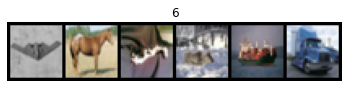

In [74]:
show_samples_redefine(image,6)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


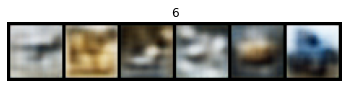

In [86]:
latent_sample = encoder(image).detach()
x_sample = decoder(latent_sample).detach()
show_samples_redefine(x_sample,6)